### Juan Felipe Osorio Franco

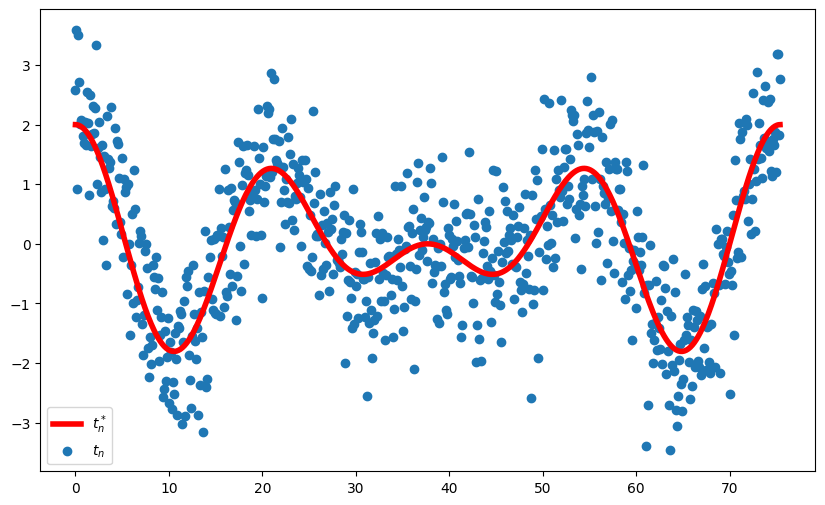

In [115]:
import numpy as np
import matplotlib.pyplot as plt

N = 700
x_n = np.linspace(0,24*np.pi,N)
t_n = np.cos(x_n/3)+np.cos(x_n/4)

# SNR deseado en decibeles
desired_snr_db = 2

# Conversion de SNR a escala lineal
desired_snr = 10 ** (desired_snr_db / 10)

# Calcular la potencia (varianza) del ruido
signal_power = np.mean(np.square(t_n))
noise_power = signal_power / desired_snr
var_r = noise_power

# Añadir ruido con el SNR deseado
t_nr = t_n + np.sqrt(var_r)*np.random.randn(N)

plt.figure(figsize=(10,6))
plt.plot(x_n,t_n,label='$t_n^*$',c='r',linewidth=4)
plt.scatter(x_n,t_nr,label='$t_n$')
plt.legend()
plt.show()

In [116]:
#mapeo no lineal
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # MSE Como metrica para el modelo

# Se añade los datos de la señal real (t_n) en wave_test para poder visualizar la diferencia entre la solucion del modelo y la señal real
X_train, X_test, t_train, t_test, _, wave_test = train_test_split(x_n.reshape(-1,1), t_nr.reshape(-1,1), t_n.reshape(-1,1),
                                                    test_size=200/N, random_state=42)

print(X_train.shape,X_test.shape,t_train.shape,t_test.shape)


def transform_data(data, Q):
  # Phi polinomial de orden features
  poly = PolynomialFeatures(Q)

  # MinMax Scaler
  scaler = MinMaxScaler()

  # Aplicamos la trnasformacion polinomial
  Phi = poly.fit_transform(data)

  # MinMax Scaler
  scaler.fit(Phi)
  Phi = scaler.transform(Phi)

  return Phi

(500, 1) (200, 1) (500, 1) (200, 1)


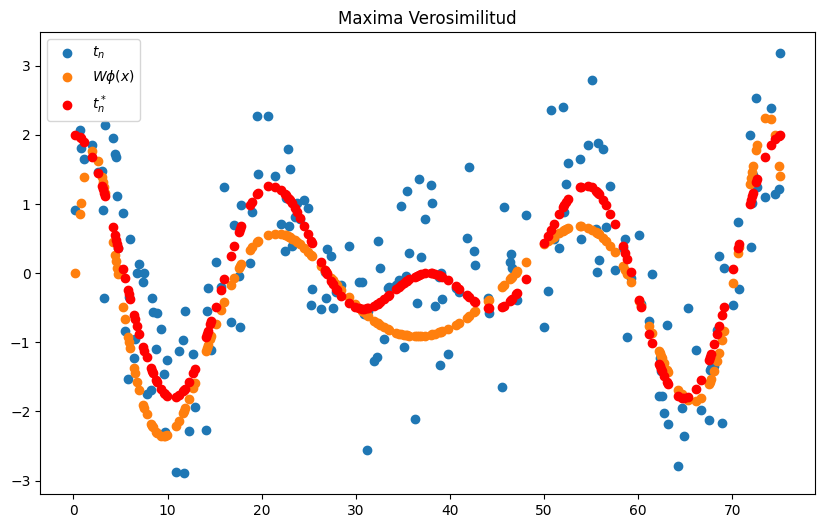

MSE = 0.8693803472629241


In [127]:
poly_order = 10  # Orden de la transformacion polinomial

def my_mincua(X, t):

  Phi = transform_data(X, poly_order)

  # Solucion minimos cuadrados

  W = np.linalg.pinv(Phi.T.dot(Phi)).dot(Phi.T).dot(t)

  return W

# Modelo por Maxima Verosimilitud (Minimos Cuadrados)
W_ml = my_mincua(X_train, t_train)

# Transformamos el set de testeo
Phi = transform_data(X_test, poly_order)

# Prediccion del modelo
t_pred = Phi.dot(W_ml)

plt.figure(figsize=(10,6))
plt.title("Maxima Verosimilitud")
plt.scatter(X_test, t_test, label='$t_n$')            # Señal Original
plt.scatter(X_test, t_pred, label='$W \phi (x)$')     # Señal Reconstruida
plt.scatter(X_test, wave_test, label='$t_n^*$',c='r') # Señal Real
plt.legend()
plt.show()

# Error del modelo
error = mean_squared_error(t_test, t_pred)
print(f"MSE = {error}")

0.6336614473851083


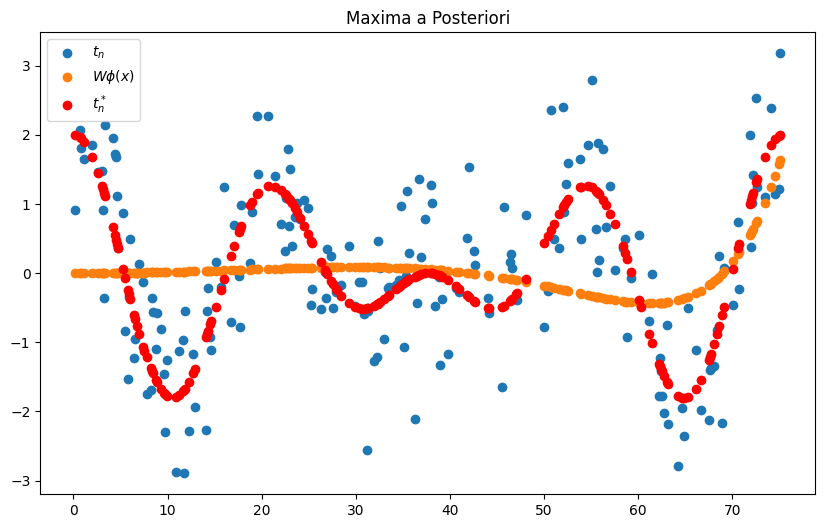

MSE = 1.3880975422219097


In [131]:
poly_order = 10  # Orden de la transformacion polinomial

def my_map(X, t):
  sigma_w = 1.0
  sigma_eta = var_r


  Phi = transform_data(X, poly_order)

  # Phi es de NxQ, Phi.T @ Phi es de QxQ, la identidad debe ser de QxQ tambien

  I = np.identity(Phi.shape[1])

  # Solucion minimos cuadrados regularizados (MAP con prior gaussiano)
  print(sigma_eta / sigma_w)
  W = np.linalg.inv((Phi.T.dot(Phi)) + (sigma_eta / sigma_w) * I).dot(Phi.T).dot(t)

  return W

# Modelo por Maxima a Posteriori
W_map = my_map(X_train, t_train)

# Transformamos el set de testeo
Phi = transform_data(X_test, poly_order)

# Prediccion del modelo
t_pred = Phi.dot(W_map)

plt.figure(figsize=(10,6))
plt.title("Maxima a Posteriori")
plt.scatter(X_test, t_test, label='$t_n$')            # Señal Original
plt.scatter(X_test, t_pred, label='$W \phi (x)$')     # Señal Reconstruida
plt.scatter(X_test, wave_test, label='$t_n^*$',c='r') # Señal Real
plt.legend()
plt.show()

# Error del modelo
error = mean_squared_error(t_test, t_pred)
print(f"MSE = {error}")